# Implementing Potential Improvements

This code notebook will run through improving the dataset and passing the improved version into the 4 models to see if it improves model performance.

Things I will do to try and improve model performance:

1. Removing outlier years
1. Removing outlier datapoints
1. Removing features which were given 0 weight by lasso


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [2]:
df = pd.read_csv('../data/outputs/final_df.csv',index_col = 0)
coef_values = pd.read_csv('../data/outputs/coef_values.csv',index_col=0)

Loading in the final dataframe done in the previous notebook, and also coef_values which I will use to remove features in this notebook.

# Removing Outliers

In [3]:
df.corr(numeric_only=True)['resale_price'].sort_values(ascending=False)

resale_price                 1.000000
floor_area_sqm               0.654120
id                           0.521504
max_floor_lvl                0.495650
5room_sold                   0.359434
year_completed               0.353698
upper                        0.353552
mid                          0.353213
lower                        0.352466
lease_commence_date          0.350337
exec_sold                    0.337500
Hawker_Within_2km            0.183168
sec_sch_longitude            0.108911
Mall_Within_2km              0.108648
pri_sch_longitude            0.106681
Longitude                    0.106596
mrt_longitude                0.106506
bus_stop_longitude           0.106394
sec_sch_nearest_dist         0.095339
4room_sold                   0.092600
Hawker_Within_1km            0.090516
Mall_Within_500m             0.085151
Mall_Within_1km              0.078815
mrt_interchange              0.066413
studio_apartment_sold        0.040312
multigen_sold                0.037406
cutoff_point

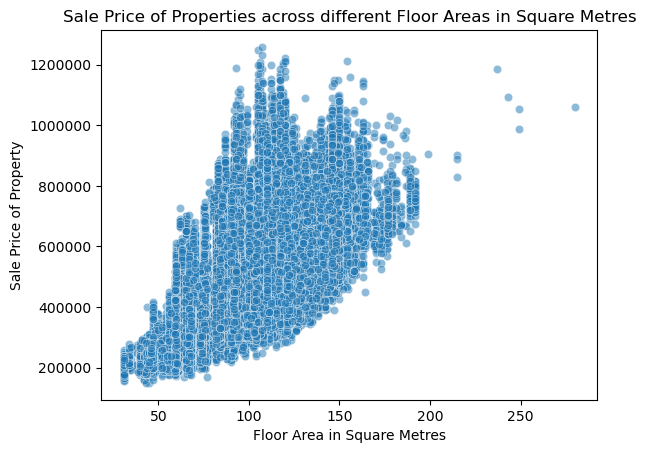

In [4]:
plt.figure(dpi=100)
sns.scatterplot(x = 'floor_area_sqm', y = 'resale_price',data=df,alpha = 0.5)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Floor Area in Square Metres')
plt.ylabel('Sale Price of Property')
plt.title('Sale Price of Properties across different Floor Areas in Square Metres');

As mentioned previously, from this scatterplot we can see that there are outliers in the data. I will filter them out and remove them from the dataset to see if it improves performance of the models.

In [5]:
df[(df['floor_area_sqm'] > 200) & (df['resale_price'] > 800000)]

,id,floor_area_sqm,lease_commence_date,resale_price,Tranc_Year,Tranc_Month,lower,upper,mid,max_floor_lvl,...,sec_sch_longitude,town,flat_type,storey_range,flat_model,commercial,market_hawker,multistorey_carpark,precinct_pavilion,mrt_name
371,28091,280.0,1972,1060000.0,2015,3,1,3,2,2,...,103.860970,KALLANG/WHAMPOA,3 ROOM,01 TO 03,Terrace,N,N,N,N,Toa Payoh
1258,146002,243.0,1990,1092888.0,2021,3,7,9,8,10,...,103.829910,BISHAN,EXECUTIVE,07 TO 09,Maisonette,N,N,N,N,Marymount
5341,57606,249.0,1972,988888.0,2012,8,1,3,2,2,...,103.860970,KALLANG/WHAMPOA,3 ROOM,01 TO 03,Terrace,N,N,N,N,Boon Keng
17097,48229,215.0,1972,830000.0,2017,6,1,3,2,2,...,103.860970,KALLANG/WHAMPOA,3 ROOM,01 TO 03,Terrace,N,N,N,N,Boon Keng
41904,111503,215.0,1998,900000.0,2018,1,10,12,11,13,...,103.746036,CHOA CHU KANG,EXECUTIVE,10 TO 12,Premium Maisonette,N,N,N,N,Yew Tee
42650,71384,215.0,1998,888000.0,2017,9,16,18,17,18,...,103.746036,CHOA CHU KANG,EXECUTIVE,16 TO 18,Premium Maisonette,N,N,N,N,Yew Tee
60635,63429,237.0,1972,1185000.0,2018,9,1,3,2,2,...,103.860970,KALLANG/WHAMPOA,3 ROOM,01 TO 03,Terrace,N,N,N,N,Boon Keng
79886,57605,249.0,1972,1053888.0,2017,12,1,3,2,2,...,103.860970,KALLANG/WHAMPOA,3 ROOM,01 TO 03,Terrace,N,N,N,N,Boon Keng


These are the 8 outliers from the highest correlated feature (floor_area_sqm) against the target variable. I will remove these rows.

In [6]:
df = df[~((df['floor_area_sqm'] > 200) & (df['resale_price'] > 800000))]

## Removing Outlier Years

Referring back to the lineplot in the first code notebook. There were years with huge dips and spikes in resale price due to cooling measures implemented by the government.

Specifically between these periods:

1. 2013 May - 2014 November
1. 2020 July - 2021 March (Also the last recorded datapoint)

I will remove all rows between these two time periods.

In [7]:
df = df[~((df['Tranc_Year'] == 2013) & (df['Tranc_Month'].isin(range(5,13))))]

Removing rows from 2013 May to 2013 Dec.

In [8]:
df = df[~((df['Tranc_Year'] == 2014) & (df['Tranc_Month'].isin(range(1,12))))]

Removing rows from 2014 Jan to 2014 November

In [9]:
df = df[~((df['Tranc_Year'] == 2020) & (df['Tranc_Month'].isin(range(7,13))))]

Removing rows from 2020 Jul - 2020 Dec

In [10]:
df = df[~((df['Tranc_Year'] == 2021) & (df['Tranc_Month'].isin(range(1,4))))]

Removing rows from 2021 Jan - 2021 Mar

In [11]:
df

,id,floor_area_sqm,lease_commence_date,resale_price,Tranc_Year,Tranc_Month,lower,upper,mid,max_floor_lvl,...,sec_sch_longitude,town,flat_type,storey_range,flat_model,commercial,market_hawker,multistorey_carpark,precinct_pavilion,mrt_name
0,88471,90.0,2006,680000.0,2016,5,10,12,11,25,...,103.882504,KALLANG/WHAMPOA,4 ROOM,10 TO 12,Model A,N,N,N,N,Kallang
1,122598,130.0,1987,665000.0,2012,7,7,9,8,9,...,103.854892,BISHAN,5 ROOM,07 TO 09,Improved,N,N,N,N,Bishan
3,86070,103.0,1992,550000.0,2012,4,1,5,3,11,...,103.844934,BISHAN,4 ROOM,01 TO 05,Model A,Y,N,N,N,Bishan
4,153632,83.0,1987,298000.0,2017,12,1,3,2,4,...,103.838335,YISHUN,4 ROOM,01 TO 03,Simplified,N,N,N,N,Khatib
5,26610,65.0,1975,335000.0,2013,1,7,9,8,12,...,103.882504,GEYLANG,3 ROOM,07 TO 09,Improved,Y,N,N,N,MacPherson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150626,9574,67.0,1976,300000.0,2016,10,1,3,2,11,...,103.813208,BUKIT MERAH,3 ROOM,01 TO 03,New Generation,N,N,N,N,Telok Blangah
150627,140504,111.0,2001,385000.0,2018,4,10,12,11,16,...,103.814471,SEMBAWANG,5 ROOM,10 TO 12,Premium Apartment,N,N,N,N,Sembawang
150630,147177,110.0,2001,455000.0,2017,6,4,6,5,16,...,103.701703,JURONG WEST,5 ROOM,04 TO 06,Improved,N,N,N,N,Pioneer
150632,21309,59.0,1974,338000.0,2016,5,7,9,8,10,...,103.801724,QUEENSTOWN,3 ROOM,07 TO 09,Improved,N,N,N,N,Commonwealth


DataFrame without outlier years

# Preprocessing the Updated Dataset

In [12]:
X = df.drop(['resale_price','id'],axis = 1)
y = df['resale_price']

## Train Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Imputing Missing Values

In [14]:
imp_median = SimpleImputer(strategy='median')

X_train['Mall_Nearest_Distance_Imputed'] = imp_median.fit_transform(X_train['Mall_Nearest_Distance'].values.reshape(-1,1))
X_test['Mall_Nearest_Distance_Imputed'] = imp_median.transform(X_test['Mall_Nearest_Distance'].values.reshape(-1,1))

X_train = X_train.drop('Mall_Nearest_Distance',axis = 1)
X_test = X_test.drop('Mall_Nearest_Distance',axis = 1)

## Separating into Numerical and Categorical Features

In [15]:
X_train_objs = X_train.select_dtypes(include='object')
X_train_nums = X_train.select_dtypes(exclude = 'object')

X_test_objs = X_test.select_dtypes(include='object')
X_test_nums = X_test.select_dtypes(exclude = 'object')

## One-Hot Encoding

In [16]:
ohe = OneHotEncoder(drop='first',sparse_output=False)

ohe_X_train_objs = pd.DataFrame(ohe.fit_transform(X_train_objs))
ohe_X_train_objs.columns = ohe.get_feature_names_out(input_features=X_train_objs.columns)

ohe_X_test_objs = pd.DataFrame(ohe.transform(X_test_objs))
ohe_X_test_objs.columns = ohe.get_feature_names_out(input_features=X_test_objs.columns)

## Scaling

In [17]:
scaler = StandardScaler()

scaled_X_train_nums = scaler.fit_transform(X_train_nums.drop(['affiliation','pri_sch_affiliation','bus_interchange','mrt_interchange'],axis = 1))
scaled_X_train_nums = pd.DataFrame(scaled_X_train_nums,columns=X_train_nums.drop(['affiliation','pri_sch_affiliation','bus_interchange','mrt_interchange'],axis = 1).columns)
scaled_X_train_nums[['affiliation','pri_sch_affiliation','bus_interchange','mrt_interchange']] = X_train_nums[['affiliation','pri_sch_affiliation','bus_interchange','mrt_interchange']].reset_index(drop=True)

scaled_X_test_nums = scaler.transform(X_test_nums.drop(['affiliation','pri_sch_affiliation','bus_interchange','mrt_interchange'],axis = 1))
scaled_X_test_nums = pd.DataFrame(scaled_X_test_nums,columns=X_test_nums.drop(['affiliation','pri_sch_affiliation','bus_interchange','mrt_interchange'],axis = 1).columns)
scaled_X_test_nums[['affiliation','pri_sch_affiliation','bus_interchange','mrt_interchange']] = X_test_nums[['affiliation','pri_sch_affiliation','bus_interchange','mrt_interchange']].reset_index(drop=True)


## Merging back Features

In [18]:
final_X_train = pd.concat([ohe_X_train_objs,scaled_X_train_nums],axis=1)
final_X_test = pd.concat([ohe_X_test_objs,scaled_X_test_nums],axis=1)

# Removing Features

In [19]:
coef_values

,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,town_CLEMENTI,town_GEYLANG,...,pri_sch_longitude,sec_sch_nearest_dist,cutoff_point,sec_sch_latitude,sec_sch_longitude,Mall_Nearest_Distance_Imputed,affiliation,pri_sch_affiliation,bus_interchange,mrt_interchange
coef_values,-46248.945827,80730.179525,-0.0,-22838.366171,-6911.674111,133207.546182,0.0,-22000.539823,11005.193725,-28092.384954,...,-0.0,4257.272887,0.0,0.0,0.0,-948.998001,14828.569552,-0.0,11803.518766,1167.094374


Recall that in the Lasso Regression model, it weighted a lot of features as having no importance. I have imported those coefficient values in the dataframe shown above.

I will now remove all features with coefficient values of 0 in an attempt to improve model performance.

In [20]:
zero_cols = coef_values.columns[(coef_values == 0).any() | (coef_values == -0).any()]

Filtering out the column with coefficient values of 0.

In [21]:
zero_cols

Index(['town_BUKIT BATOK', 'town_CENTRAL AREA', 'town_HOUGANG', 'town_PUNGGOL',
       'town_SEMBAWANG', 'town_SENGKANG', 'town_TAMPINES', 'flat_type_2 ROOM',
       'flat_type_3 ROOM', 'flat_type_5 ROOM',
       ...
       '3room_sold', 'Latitude', 'Longitude', 'bus_stop_latitude',
       'bus_stop_longitude', 'pri_sch_longitude', 'cutoff_point',
       'sec_sch_latitude', 'sec_sch_longitude', 'pri_sch_affiliation'],
      dtype='object', length=117)

In [22]:
for column in zero_cols:
    final_X_train = final_X_train.drop(column,axis =1)

In [23]:
for column in zero_cols:
    final_X_test = final_X_test.drop(column,axis =1)

In [24]:
final_X_train.head()

,town_BEDOK,town_BISHAN,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CHOA CHU KANG,town_CLEMENTI,town_GEYLANG,town_JURONG EAST,town_JURONG WEST,...,mrt_longitude,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_latitude,sec_sch_nearest_dist,Mall_Nearest_Distance_Imputed,affiliation,bus_interchange,mrt_interchange
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.253444,-0.250548,-0.794198,-0.066215,0.845266,0.177444,0.064720,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.218093,-0.694973,-0.864569,-0.906852,-0.500232,-0.345008,1.245232,0,1,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.253444,-0.432197,0.163846,0.606294,0.664129,-1.026822,-1.501913,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.529538,-0.964776,-0.094989,-0.850809,-0.026496,-1.252239,0.110825,0,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.421931,0.409785,1.017090,-0.290385,-0.824019,0.654699,0.388048,0,0,0


In [25]:
final_X_test.head()

,town_BEDOK,town_BISHAN,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CHOA CHU KANG,town_CLEMENTI,town_GEYLANG,town_JURONG EAST,town_JURONG WEST,...,mrt_longitude,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_latitude,sec_sch_nearest_dist,Mall_Nearest_Distance_Imputed,affiliation,bus_interchange,mrt_interchange
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-1.946157,0.557021,-0.543683,0.606294,-0.419008,1.910152,-0.099449,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.159681,0.152617,1.859840,-1.074979,0.122473,1.263823,0.653896,0,1,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.297576,-0.349221,-0.506099,-0.962894,0.353211,0.092864,-0.672358,0,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.885957,-1.266242,-0.913699,2.007354,0.779495,-0.299243,-1.462495,0,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.443414,0.802825,-0.595083,0.270039,-1.651267,-0.033381,-0.047805,0,0,0


Final X train and test with features removed.

# Model Fitting

## OLS

In [26]:
lr_model = LinearRegression()
lr_model.fit(final_X_train,y_train)

LinearRegression()

In [27]:
print(f'R^2 score for training set is {lr_model.score(final_X_train,y_train)}')
print(f'R^2 score for test set is {lr_model.score(final_X_test,y_test)}')
print(f'Mean R^2 score with 5 fold cross validation on training set is {cross_val_score(lr_model,final_X_train,y_train,cv = 5).mean()}')

y_pred = lr_model.predict(final_X_test)
print(f'MAE is {metrics.mean_absolute_error(y_test,y_pred)}')
print(f'RMSE is {np.sqrt(metrics.mean_squared_error(y_test,y_pred))}')

R^2 score for training set is 0.9011420205769982
R^2 score for test set is 0.9001854086698813
Mean R^2 score with 5 fold cross validation on training set is 0.9007674605830562
MAE is 34058.61392110168
RMSE is 45379.012744434345


## Lasso Regression

In [28]:
lasso_model = LassoCV(max_iter = 10000,cv = 5, verbose = 1)
lasso_model.fit(final_X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


LassoCV(cv=5, max_iter=10000, verbose=1)

In [29]:
alpha = lasso_model.alpha_
alpha

93.48557750371843

In [30]:
print(f'R^2 score for training set is {lasso_model.score(final_X_train,y_train)}')
print(f'R^2 score for test set is {lasso_model.score(final_X_test,y_test)}')
print(f'Mean R^2 score with optimal alpha value is {cross_val_score(Lasso(alpha=alpha),final_X_train,y_train,cv=5).mean()}')

y_pred_lasso = lasso_model.predict(final_X_test)
print(f'MAE is {metrics.mean_absolute_error(y_test,y_pred_lasso)}')
print(f'RMSE is {np.sqrt(metrics.mean_squared_error(y_test,y_pred_lasso))}')

R^2 score for training set is 0.896883957874116
R^2 score for test set is 0.8955101015523094
Mean R^2 score with optimal alpha value is 0.8964495536481131
MAE is 34653.88367142669
RMSE is 46429.62545955131


## Ridge Regression

In [31]:
r_alphas = np.logspace(0, 5, 100) # setting up my alphas to pass into the model
ridge_model = RidgeCV(alphas = r_alphas, scoring = 'r2', cv = 5)
ridge_model.fit(final_X_train,y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5, scoring='r2')

In [32]:
alpha = ridge_model.alpha_
alpha

1.0

In [33]:
print(f'R^2 score for training set is {ridge_model.score(final_X_train,y_train)}')
print(f'R^2 score for test set is {ridge_model.score(final_X_test,y_test)}')
print(f'Mean R^2 score with optimal alpha value is {cross_val_score(Ridge(alpha=alpha),final_X_train,y_train,cv=5).mean()}')

y_pred_ridge = ridge_model.predict(final_X_test)
print(f'MAE is {metrics.mean_absolute_error(y_test,y_pred_ridge)}')
print(f'RMSE is {np.sqrt(metrics.mean_squared_error(y_test,y_pred_ridge))}')

R^2 score for training set is 0.9011457439671443
R^2 score for test set is 0.9001660001657233
Mean R^2 score with optimal alpha value is 0.9007686804684836
MAE is 34063.19184171182
RMSE is 45383.42440377204


## ElasticNet Regression

In [34]:
en_model = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1],max_iter = 10000,verbose = 1)
en_model.fit(final_X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=10000,
             verbose=1)

In [35]:
l1_ratio = en_model.l1_ratio_
print(en_model.l1_ratio_)
alpha = en_model.alpha_
alpha

1.0


93.48557750371843

In [36]:
print(f'R^2 score for training set is {en_model.score(final_X_train,y_train)}')
print(f'R^2 score for test set is {en_model.score(final_X_test,y_test)}')
print(f'Mean R^2 score with optimal alpha value is {cross_val_score(ElasticNet(alpha=alpha,l1_ratio = l1_ratio),final_X_train,y_train,cv=5).mean()}')

y_pred_en = en_model.predict(final_X_test)
print(f'MAE is {metrics.mean_absolute_error(y_test,y_pred_en)}')
print(f'RMSE is {np.sqrt(metrics.mean_squared_error(y_test,y_pred_en))}')

R^2 score for training set is 0.896883957874116
R^2 score for test set is 0.8955101015523094
Mean R^2 score with optimal alpha value is 0.8964495536481131
MAE is 34653.88367142669
RMSE is 46429.62545955131


In [37]:
print(" Multiple Linear Regression ".center(18, "="))# syntax: str.center(width, fillchar=' ')
print(lr_model.score(final_X_train, y_train))
print(lr_model.score(final_X_test, y_test))
print(f'RMSE is {np.sqrt(metrics.mean_squared_error(y_test,y_pred))}')
print()
print(" Lasso ".center(18, "="))
print(lasso_model.score(final_X_train, y_train))
print(lasso_model.score(final_X_test, y_test))
print(f'RMSE is {np.sqrt(metrics.mean_squared_error(y_test,y_pred_lasso))}')
print()
print(" Ridge ".center(18, "="))
print(ridge_model.score(final_X_train, y_train))
print(ridge_model.score(final_X_test, y_test))
print(f'RMSE is {np.sqrt(metrics.mean_squared_error(y_test,y_pred_ridge))}')
print()
print(" ElasticNet ".center(18, "="))
print(en_model.score(final_X_train, y_train))
print(en_model.score(final_X_test, y_test))
print(f'RMSE is {np.sqrt(metrics.mean_squared_error(y_test,y_pred_en))}')

====== OLS =======
0.9011420205769982
0.9001854086698813
RMSE is 45379.012744434345

===== Lasso ======
0.896883957874116
0.8955101015523094
RMSE is 46429.62545955131

===== Ridge ======
0.9011457439671443
0.9001660001657233
RMSE is 45383.42440377204

=== ElasticNet ===
0.896883957874116
0.8955101015523094
RMSE is 46429.62545955131


| Model                                | R-Squared Score - Training Set | R-Squared Score - Test Set | Cross-Validated R-Squared Score folds = 5 | RMSE  |
|--------------------------------------|--------------------------------|----------------------------|-------------------------------------------|-------|
| Multiple Linear Regression                                | 0.90                           | 0.90                       | 0.90                                      | 44828 |
| Lasso  alpha = 93.6                  | 0.89                           | 0.89                       | 0.89                                      | 47068 |
| Ridge alpha = 1                      | 0.90                           | 0.90                       | 0.90                                      | 44816 |
| ElasticNet l1_ratio = 1 alpha = 93.6 | 0.89                           | 0.89                       | 0.89                                      | 47068 |



| Model after removing outliers and 0 weighted features by Lasso| R-Squared Score - Training Set | R-Squared Score - Test Set | Cross-Validated R-Squared Score folds = 5 | RMSE  |
|--------------------------------------|--------------------------------|----------------------------|-------------------------------------------|-------|
| Multiple Linear Regression                                 | 0.90                           | 0.90                       | 0.90                                      | 45379 |
| Lasso  alpha = 93.6                  | 0.89                           | 0.89                       | 0.89                                      | 46429 |
| Ridge alpha = 1                      | 0.90                           | 0.90                       | 0.90                                      | 45383 |
| ElasticNet l1_ratio = 1 alpha = 93.6 | 0.89                           | 0.89                       | 0.89                                      | 46429 |


Surprisingly, after removing the outlier years and datapoints, the new models are performing almost exactly the same and maybe slightly even worse based on the RMSE.

This could mean that the outliers were not actually having as big of an impact on the model than we thought, or that the outliers actually contain valuable information in predicting the target variable.

Or that the outliers were actually containing valuable information in predicting the target variable.

Taking this into consideration,I will stick to the initial data with outlier years/datapoints and all features for the final model.

The next notebook will go through training the final model on the entire training set before submission to Kaggle.